In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pylab as plt

In [4]:
from tvb.simulator.lab import *

2022-11-29 10:36:30,960 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


/home/izaak/local_repos/nostromo/tvb-root/tvb_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


The simulator backends provide pluggable numerical implementations, allowing for different implementations or strategies. The goal is to separarte better the implementation and configuration of the computationally intensive numerical integration from the configuration of the simulation. 

The backend consumes the `simulator.Simulator` instance, and performs the computation. Not all components have to be supported by all backends.

Here we demo two backends with different purposes. The Numba accelerated `NbMPRBackend` implementing the `models.MontbrioPazoRoxin` model, and the plain NumPy `NpBackend` which produces readable concise code ideal for learning purposes.

In [5]:
from tvb.simulator.backend.nb_mpr import NbMPRBackend
from tvb.simulator.backend.np import NpBackend

The configuration of the `simulator.Simulator` is as usual:

In [6]:
conn = connectivity.Connectivity.from_file() # default 76 regions 
conn.speed = np.array([2.0])  
np.fill_diagonal(conn.weights, 0.)
conn.weights = conn.weights/np.max(conn.weights)
conn.configure()

sim = simulator.Simulator(
    model=models.MontbrioPazoRoxin(
        eta   = np.r_[-4.6],
        J     = np.r_[14.5],
        Delta = np.r_[ 0.7],
        tau   = np.r_[ 1.0],
    ),
    connectivity=conn,
    coupling=coupling.Linear(
      a=np.r_[0.095]
    ),
    conduction_speed=conn.speed.item(),
    integrator=integrators.HeunStochastic(
      dt=0.01,
      noise=noise.Additive(
          nsig=np.r_[0.01, 0.02],
          noise_seed=42
      )
    ),
    monitors=[
      monitors.Raw(),
    ]
).configure();

WARNING  File 'hemispheres' not found in ZIP.


When we run this with the `NbMPRBackend`, we get around 6x speedup:

In [7]:
%%time
(tavg_t, tavg_d), = NbMPRBackend().run_sim(sim, simulation_length=2000)

CPU times: user 9.84 s, sys: 76.2 ms, total: 9.92 s
Wall time: 9.98 s


In [8]:
%%time
_ = sim.run(simulation_length=2000)

CPU times: user 59.2 s, sys: 333 ms, total: 59.6 s
Wall time: 1min


Below is just a visual check, however the correctness of the backend implementations is systematically tested. See `tvb/tests/library/simulator/backend/`.

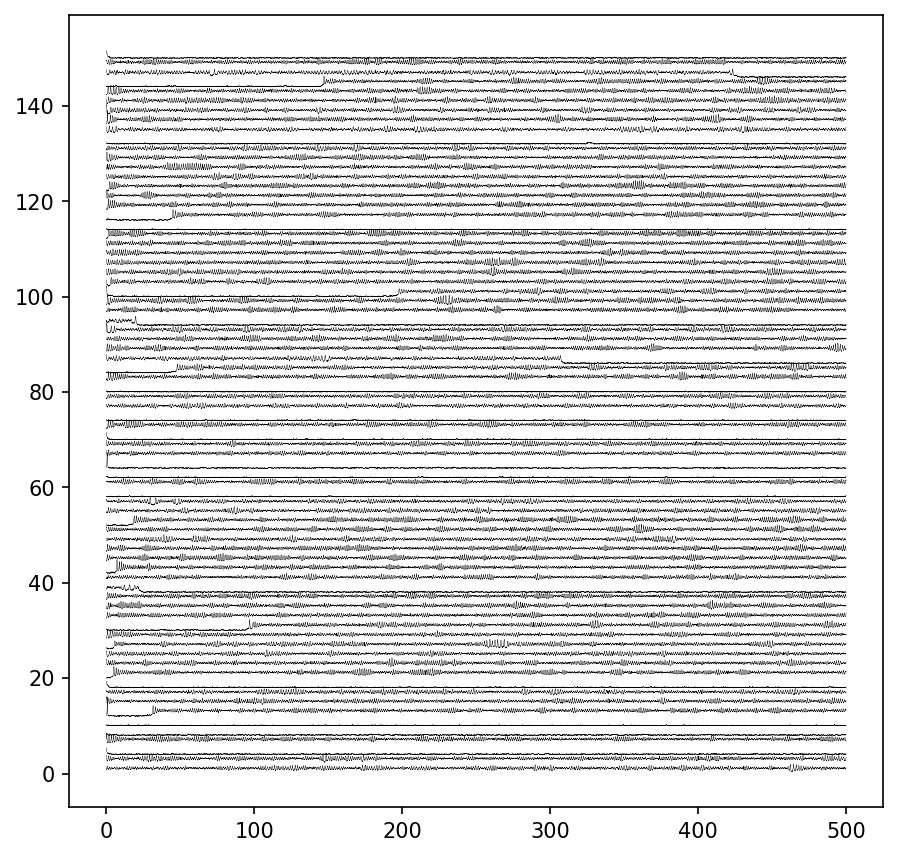

In [9]:
plt.figure(figsize=(7,7),dpi=150)
plt.plot(tavg_t[:100*500], tavg_d[:100*500,0,:,0] + 2.*np.arange(sim.connectivity.number_of_regions),lw=0.2,c='k');

The same simulation can be passed through the `NpBackend` with `print_source=True` to inspect the generated code. The output below is easy to navigate and understand as it only contains code relevant to this simulator instance.

In [10]:
_ = NpBackend().run_sim(sim, nstep=1, print_source=True)

001	#
002	#
003	# TheVirtualBrain-Scientific Package. This package holds all simulators, and
004	# analysers necessary to run brain-simulations. You can use it stand alone or
005	# in conjunction with TheVirtualBrain-Framework Package. See content of the
006	# documentation-folder for more details. See also http://www.thevirtualbrain.org
007	#
008	# (c) 2012-2022, Baycrest Centre for Geriatric Care ("Baycrest") and others
009	#
010	# This program is free software: you can redistribute it and/or modify it under the
011	# terms of the GNU General Public License as published by the Free Software Foundation,
012	# either version 3 of the License, or (at your option) any later version.
013	# This program is distributed in the hope that it will be useful, but WITHOUT ANY
014	# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
015	# PARTICULAR PURPOSE.  See the GNU General Public License for more details.
016	# You should have received a copy of the GNU General P